# Speech Emotion Recognition CNN (using MFCC features)
### RAVDESS Dataset
### Made by LuisFraga
### January, 2020

In [1]:
import gc
gc.collect()
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# import soundfile # to read audio file
import numpy as np
import librosa # to extract speech features
import glob, os
import pandas as pd
import pickle # to save model after training
from sklearn.model_selection import train_test_split

## Extract Speech Features (MFCC)

In [3]:
def extract_features(file_path):
    max_pad_len = 300
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')        
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    
        shape = mfccs.shape[1]
                     
        if max_pad_len > mfccs.shape[1]:
            pad_width = max_pad_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

        else:
            mfccs = mfccs[:, :max_pad_len]
            
    except Exception as e:
        print("Error encountered while parsing file: ", file_path)
        mfccs = "error"
        return mfccs
        
    return mfccs

## Data Augmentation

In [ ]:
import random

def noise_aug(data, noise_factor):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

def pitch_aug(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def speed_aug(data, speed_factor):
    return librosa.effects.time_stretch(data, speed_factor)
    
def extract_feat(X, sample_rate):
    max_pad_len = 300
    try:  
        mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)    
        shape = mfccs.shape[1]
                     
        if max_pad_len > mfccs.shape[1]:
            pad_width = max_pad_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

        else:
            mfccs = mfccs[:, :max_pad_len]
            
    except Exception as e:
        print("Error encountered while parsing file: ", file_path)
        mfccs = "error"
        return mfccs
    
    return mfccs

def data_augmented():
    X, y = [], []
    i = 0
    for file in glob.glob("dataset/Actor_*/*.wav"):
        basename = os.path.basename(file)
        print("File:", i+1)
        i += 1
        emotion = int2emotion[basename.split("-")[2]]
        if emotion not in AVAILABLE_EMOTIONS:
            continue
       
        audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
        noise = noise_aug(audio, random.uniform(-0.25,0.25)) 
        pitch = pitch_aug(audio, sample_rate, random.uniform(-0.25,0.25)) 
        speed = speed_aug(audio, random.uniform(0.75, 1.25))
        
        ### Extract Feat
        features = extract_feat(audio, sample_rate)
        X.append(features)
        y.append(emotion)
        
        features = extract_feat(noise, sample_rate)
        X.append(features)
        y.append(emotion)
        
        features = extract_feat(pitch, sample_rate)
        X.append(features)
        y.append(emotion)
        
        features = extract_feat(speed, sample_rate)
        X.append(features)
        y.append(emotion)
        
    return np.array(X), y

## Load Dataset + Features

In [4]:
### Dataset available emotions
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

### Emotions that we gonna use
AVAILABLE_EMOTIONS = {
    "angry",
    "sad",
    "neutral",
    "happy",
    "calm"
}

def load_data():
    X, y = [], []
    for file in glob.glob("dataset/Actor_*/*.wav"):
        basename = os.path.basename(file)
        emotion = int2emotion[basename.split("-")[2]]
        if emotion not in AVAILABLE_EMOTIONS:
            continue
        features = extract_features(file)

        if emotion == "calm":
            emotion = "neutral"

        X.append(features)
        y.append(emotion)

    return np.array(X), y

X, y = load_data()

## Prepare Train/Test Data

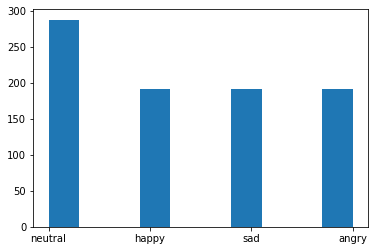

In [5]:
import matplotlib.pyplot as plt
plt.hist(y)
plt.show()

In [6]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder


lb = LabelEncoder()
y_cat = np_utils.to_categorical(lb.fit_transform(y))

X_train, X_test, y_train, y_test, Y_train, Y_test = train_test_split(np.array(X), y_cat, y, test_size = 0.20)
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print("(>^.^)> X_train shape:", X_train.shape)
print("(>^.^)> y_train shape:", y_train.shape)

Using TensorFlow backend.


(>^.^)> X_train shape: (691, 40, 300, 1)
(>^.^)> y_train shape: (691, 4)


## Abdi CNN

In [7]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.callbacks import ModelCheckpoint
import keras

EPOCHS = 50
CONV_DIM = 128
BATCH_SIZE = 32
HIDDEN_DIM = 128
INPUT_DIM = X_train.shape[1]
inputShape = (40, 300, 1)
chanDim = -1 
classes = y_train.shape[1]

cnn_model = Sequential()

cnn_model.add(Conv2D(CONV_DIM, (3, 3), padding="same", input_shape=inputShape))
cnn_model.add(Activation("relu"))
cnn_model.add(BatchNormalization(axis=chanDim))
cnn_model.add(MaxPooling2D(pool_size=(3, 3)))
cnn_model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
cnn_model.add(Conv2D(2*CONV_DIM, (3, 3), padding="same"))
cnn_model.add(Activation("relu"))
cnn_model.add(BatchNormalization(axis=chanDim))
cnn_model.add(Conv2D(2*CONV_DIM, (3, 3), padding="same"))
cnn_model.add(Activation("relu"))
cnn_model.add(BatchNormalization(axis=chanDim))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
# cnn_model.add(Conv2D(4*CONV_DIM, (3, 3), padding="same"))
# cnn_model.add(Activation("relu"))
# cnn_model.add(BatchNormalization(axis=chanDim))
# cnn_model.add(Conv2D(4*CONV_DIM, (3, 3), padding="same"))
# cnn_model.add(Activation("relu"))
# cnn_model.add(BatchNormalization(axis=chanDim))
# cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
# cnn_model.add(Dropout(0.25))

# first (and only) set of FC => RELU layers
cnn_model.add(Flatten())
cnn_model.add(Dense(HIDDEN_DIM))
cnn_model.add(Activation("relu"))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))
 
# softmax classifier
cnn_model.add(Dense(classes))
cnn_model.add(Activation("softmax"))

Adam = keras.optimizers.Adam(learning_rate=0.0001)
cnn_model.compile(loss="categorical_crossentropy", optimizer = Adam , metrics=["accuracy"])
cnn_model.summary()

# checkpoint
filepath="weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = cnn_model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, 
                         callbacks=callbacks_list, validation_data = (X_test, y_test))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 40, 300, 128)      1280      
_________________________________________________________________
activation_1 (Activation)    (None, 40, 300, 128)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 300, 128)      512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 100, 128)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 100, 128)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 100, 256)      295168    
_________________________________________________________________
activation_2 (Activation)    (None, 13, 100, 256)     

Epoch 37/50
691/691 [==============================] - 2s 3ms/step - loss: 0.0677 - accuracy: 0.9855 - val_loss: 0.5587 - val_accuracy: 0.7861
Epoch 38/50
691/691 [==============================] - 2s 3ms/step - loss: 0.0525 - accuracy: 0.9928 - val_loss: 0.5956 - val_accuracy: 0.7746
Epoch 39/50
691/691 [==============================] - 2s 3ms/step - loss: 0.0508 - accuracy: 0.9928 - val_loss: 0.5792 - val_accuracy: 0.7746
Epoch 40/50
691/691 [==============================] - 3s 4ms/step - loss: 0.0607 - accuracy: 0.9942 - val_loss: 0.5701 - val_accuracy: 0.7688
Epoch 41/50
691/691 [==============================] - 3s 4ms/step - loss: 0.0546 - accuracy: 0.9942 - val_loss: 0.5365 - val_accuracy: 0.7919
Epoch 42/50
691/691 [==============================] - 2s 4ms/step - loss: 0.0498 - accuracy: 0.9899 - val_loss: 0.6731 - val_accuracy: 0.7861
Epoch 43/50
691/691 [==============================] - 2s 3ms/step - loss: 0.0504 - accuracy: 0.9942 - val_loss: 0.5864 - val_accuracy: 0.7861

## Load the Best Weights

In [8]:
# load weights
cnn_model.load_weights("weights_best.hdf5")
# Compile model (required to make predictions)
Adam = keras.optimizers.Adam(learning_rate=0.0001)
cnn_model.compile(loss="categorical_crossentropy", optimizer= Adam, metrics=["accuracy"])

## Visualization

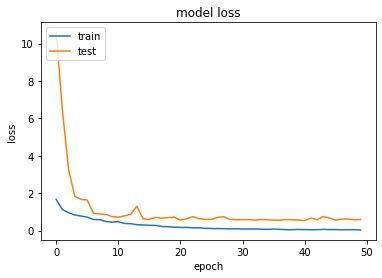

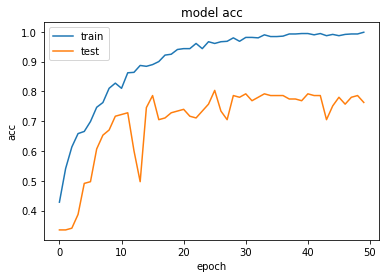

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction

In [10]:
def new_input(file_path):
    X = []
    features = extract_features(file_path)
    X.append(features)
    X = np.expand_dims(np.array(X), axis = 3)
    y_pred = cnn_model.predict(X)

    
    emotion = np.argmax(y_pred[0])
    
    if emotion == 0:
        print("Angry")
    if emotion == 1:
        print("Happy") 
    if emotion == 2:
        print("Neutral") 
    if emotion == 3:
        print("Sad") 

In [ ]:
audio_path = "User_Vocals/924/"
for file in glob.glob(audio_path + '/*.wav'):  
    basename = os.path.basename(file)

    y_pred = new_input(file)

print("------ FINISH HERE ------")